# Vocoder
Vocoder is an artificial word combined out of voice and encoder.
Vocoder is a general word for all algorithms designed to analyse and synthesize speech.
For example, they can be used to change the pitch of sound or they can align the time axis for different acoustical signals by time stretching.

The vocoder is the ideal software to analyse the properties of speech (pitch, speed, envelope, ...) and to play with these properties in order to get better insights in the topic of digital speech processing. Additionally, it can be checked, which parameters of a vocoder leads to a high quality of speech signals and which parameters leads to an acceptable speech intelligibility. For Speech recogntion software, an acceptable speech intelligibility should a sufficient as feature input for a neural network.

In the context of this lesson, the phase vocoder is used. Other vocoder types are ignored.
The phase vocoder analyses the spectrogram of the signal.
This spectrogram is modified, by e.g. a timestretch or a pitch shift.
Than the phase of the modified spectrogram is estimated. In this example, the RTISI algorithm is used for phase estimation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../Python')
import WaveInterface

## Initial Bandpass

The simplest way of denoising a sensor signal is a bandpass. If the frequency range of the wanted signal is known, all other frequencies can be suppressed. By this simple algorithm, the SNR is increased.

For human voice,the relevant frequency range is assumed in the range:

$50 \text{ Hz}< f < 7000 \text{ Hz}$.

The initial bandpass is configured by the parameters CutoffFrequencyBandpassLowInHertz and CutoffFrequencyBandpassHighInHertz.

## Changing the speed
The vocoder can be used to change the speed of the playback. For this, the synthesis windows must use a different hop size than the analysis windows. The speed can be changed by the parameter TimeStretchFactor.

## Changing the pitch
The class CTransformPitchshift evaluates a linear interpolation between two neighbouring frequency bins of the DFT.
This linear interpolation can be expressed by a matrix multiplication with the transform matrix self.__T.

The transform Matrix self.__T is evaluated each time, the parameter ShiftByFactor changes. This evaluation is done in the private procedure __EvaluateTransformMatrix.
The linear interpolation is implemented as follows: The magnitude spectrogram of the $k$-th frequency bin corresponds to the Targetfrequency $\Delta_f\cdot k$ in Hertz. The magnitude of this Targetfrequency should be the same, as the magnitude of the old spectrum $X$ at the Sourcefrequency, which is Targetfrequency changed by the shift factor.
Due to the discrete frequency resolution of the DFT, only discrete frequency bins are defined, namely $n\cdot\Delta_f$. Therefore, the new magnitude at frequency TargetFrequency cannot be directly taken from the source bin $n$. Instead, a linear interpolation of two neighbouring bins is done.

The public procedure TransformPitchshift checks, if the current ShiftByFactor is valid. If not, the transform matrix is updated. Finally, the transform matrix is applied by the call np.matmul(self.__T, X).

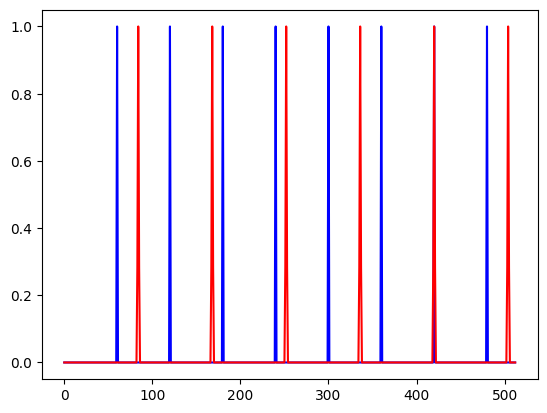

In [2]:
class CTransformPitchshift(object):
    
    def __init__(self):
        self.__ShiftByFactor = -1.0
        self.__XShape0 = 0
        
    def __EvaluateTransformMatrix(self, SamplingRate):
        FFTLen = 2*(self.__XShape0-1)
        Delta_f = SamplingRate / FFTLen
        self.__T = np.zeros((self.__XShape0, self.__XShape0))
        for k in range(self.__XShape0):
            TargetFrequency = Delta_f * k
            SourceFrequency = TargetFrequency / self.__ShiftByFactor
            if SourceFrequency < (SamplingRate / 2):
                # linear interpolation for neighbouring frequency bins
                n = int(SourceFrequency / Delta_f)
                self.__T[k, n + 1] = (SourceFrequency - n * Delta_f) / Delta_f
                self.__T[k, n + 0] = 1 - self.__T[k, n + 1]

    def TransformPitchshift(self, X, SamplingRate, ShiftByFactor):
        assert ShiftByFactor > 0, 'only positive shift factors for pitch are reasonable'
        SomethingChanged = np.abs(ShiftByFactor - self.__ShiftByFactor) > 1e-3
        SomethingChanged = SomethingChanged or (np.abs(self.__XShape0 - X.shape[0]) > 1e-3)
        if SomethingChanged:
            self.__ShiftByFactor = ShiftByFactor
            self.__XShape0 = X.shape[0]
            self.__EvaluateTransformMatrix(SamplingRate)
        return np.matmul(self.__T, X)

SamplingRate = 16000
K = 1024
NyquistIndex = K // 2 + 1
AssumedOriginalSpectrum = np.zeros((NyquistIndex))
AssumedOriginalSpectrum[60::60] = 1

ShiftByFactor = 1.4
ATransformPitchshift = CTransformPitchshift()
PitchShiftedSpectrum = ATransformPitchshift.TransformPitchshift(AssumedOriginalSpectrum, SamplingRate, ShiftByFactor)

plt.plot(AssumedOriginalSpectrum, 'b')
plt.plot(PitchShiftedSpectrum, 'r')
plt.show()

## Smoothing the spectra
The standard audio feature for speech recognition uses a log-log-spectrogram with a logarithmic magnitude and a logarithmic frequency axis.
In order to check the intelligibility of human voices after compressed to a logarithmic frequency axis by a Mel-Filterbank, the following procedure ApplyMelFilterbankAndReverse is implemented.

In the first implementation, this procedure simply returns the input value.

In the programming exercise, this procedure is replaced by the following two steps:

1) applying the Mel-Filterbank and
2) inverting step 1).

In [3]:
def ApplyMelFilterbankAndReverse(X, SamplingRate):
    return X 

## Vocoder Configuration
The vocoder allows the manipulation of human speech with mathematical algorithms controlled by a set of parameters.
The aim of this Jupyter Notebook is to give you a tool, to learn about the influence or the effect of these parameters.

Simple toy parameter are TimeStretchFactor and PitchshiftFactor. These parameters are able to change the pitch and the speed of the human voice.

Additionally, the initial bandpass can be defined by the parameters CutoffFrequencyBandpassLowInHertz and CutoffFrequencyBandpassHighInHertz. Check, which values for these both parameters leads to a high voice intelligibility.

In [4]:
# defining the vocoder parameter
import RTISI

CutoffFrequencyBandpassLowInHertz = 50
CutoffFrequencyBandpassHighInHertz = 7000
TimeStretchFactor = 1.0
PitchshiftFactor = 1.0

HopSizeInMilliseconds = 10
OverlappingInPercent = 75
MinimumFrequencyResolutionInHertz = 20

# initializing the necessary classes
ATransformPitchshift = CTransformPitchshift()

# read the input signal
#x, Fs, bits = WaveInterface.ReadWave('../Audio/P501_D_EN_fm_SWB_48k.wav')
x, Fs, bits = WaveInterface.ReadWave('../Audio/Malmsheimer48kHz.wav')
if x.shape[0] > 4*Fs: x = x[0:4*Fs]
print('Fs = ', Fs)
print('bits = ', bits)
print('duration of input signal = ', x.shape[0] / Fs, ' s')

# derived parameters and classes
hs = int(Fs * HopSizeInMilliseconds / 1000)
ws = int(hs / (1 - OverlappingInPercent/100))
w_Rectangular = np.ones((ws))
w_Hann = 0.5 - 0.5 * np.cos(2*np.pi*(np.arange(ws)+0.5)/ws)
FFTLen = int(Fs / MinimumFrequencyResolutionInHertz)
if FFTLen < ws: FFTLen = ws
FFTLen = 2*int(2**np.ceil(np.log2(FFTLen)))

Delta_f = Fs / FFTLen
CutoffIndexLowBandpass = int(CutoffFrequencyBandpassLowInHertz / Delta_f)
CutoffIndexHighBandpass = int(CutoffFrequencyBandpassHighInHertz / Delta_f) + 1

TargetHopSize = int(hs * TimeStretchFactor)

ARTISI = RTISI.CRTISI(TargetHopSize, w_Rectangular, w_Hann)

Fs =  48000
bits =  16
duration of input signal =  4.0  s


## Vocoder Implementation
The input signal $x$ is analysed blockwise:

A local spectrum SpectrumAnalysis is evaluated.
This SpectrumAnalysis is modified by different transformations/modifications, e.g. TransformSpectralEnvelope and TransformPicthshift can be applied.
The output of these transformations is the SpectrumSynthesis.
The phase estimation algorithm estimates for this new magnitude spectrum SpectrumSynthesis a phase, which is matching the spectra processed earlier.
The output signal of the phase estimation algorithm is then added to $y$ at the correct position in a overlap-add procedure.

In [5]:
y = np.zeros((int(x.shape[0] * TimeStretchFactor * 1.1)))
for NumberOfBlocks in range(int((x.shape[0] - ws) / hs)):
    # block analysis
    idx1 = NumberOfBlocks * hs
    idx2 = idx1 + ws
    BlockAnalysis = x[idx1:idx2] * w_Hann
    SpectrumAnalysis = np.abs(np.fft.rfft(BlockAnalysis, n = FFTLen))

    # bandpass
    SpectrumAnalysis[:CutoffIndexLowBandpass] = 0.0
    SpectrumAnalysis[CutoffIndexHighBandpass:] = 0.0
    
    # spectral modifications
    SmoothedSpectrum = ApplyMelFilterbankAndReverse(SpectrumAnalysis, Fs)
    SpectrumSynthesis = ATransformPitchshift.TransformPitchshift(SmoothedSpectrum, SamplingRate = Fs, ShiftByFactor = PitchshiftFactor)
    
    # evaluate a good phase for the next audio block
    BlockSynthesis = ARTISI.ProcessNewColumnOfSpectrogram(SpectrumSynthesis)
    
    # overlap add at the target position due to timestretch
    idx1 = NumberOfBlocks * TargetHopSize
    idx2 = idx1 + ws
    y[idx1:idx2] += BlockSynthesis

# saving the results
#print('Sparseness: ', ASpectralMasking.GetSparsenessFactor())
print('duration of output signal = ', y.shape[0] / Fs, ' s')
y = y *0.9 / np.amax(np.abs(y))
WaveInterface.WriteWave(y, Fs, bits, 'output.wav')


duration of output signal =  4.4  s


## Programming exercise:
In the Jupyter Notebook you have learned, that the model for human voice production is the Source Filter Model. The filter is described by the spectral envelope. If your parameter NumberOfBandsPerBark is large (the frequency resolution of the human ear is roughly $27$ bands per Bark), than the envelope is modeled very precisely. If you decrease the NumberOfBandsPerBark down to $1$, the voice quality decreases but it should still be understandable.

After applying the Mel-Filterbank, the output spectrum has a logarithmic frequency resolution. In order to make listening experiments with the vocoder, the spectrum must be transformed back into linear frequency domain.

Implement the missing procedure __EvaluateInverseTransformMatrix of the class CTransformSpectralEnvelope.
The resulting matrix self.__Tinverse should fullfill the following conditions:
1) self.__Tinverse[k, i] should be non-negative for all $k$ and all $i$,
2) each column $i$ of self.__Tinverse[k, i] should be a multiple of the corresponding row of self.__T[i, k]: self.__Tinverse[k, i] $=d[i]\cdot$self.__T[i, k] and
3) a white (constant) spectrum transformed by the procedure ApplyMelFilterbankAndReverse should stay as constant as possible.

Try out, for what smallest value of NumberOfBandsPerBark, the output of the vocoder is still understandable.

In [6]:
def Bark2KiloHertz(b):
    return 1.96 * (b + 0.53) / (26.28 - b)

def MelFilterBank(NumberOfCenterFrequenciesPerBark, NumberOfInputFrequencyBins, SamplingRate):
    FFTLen = 2 * NumberOfInputFrequencyBins - 2
    Deltaf = SamplingRate / FFTLen
    f = np.arange(NumberOfInputFrequencyBins) * Deltaf
    CutoffFrequenciesInBark = np.arange(24*NumberOfCenterFrequenciesPerBark+1) / NumberOfCenterFrequenciesPerBark
    CutoffFrequenciesInHertz = Bark2KiloHertz(CutoffFrequenciesInBark) * 1000
    CenterFrequenciesInHertz = np.diff(CutoffFrequenciesInHertz) / 2
    CenterFrequenciesInHertz += CutoffFrequenciesInHertz[0:CutoffFrequenciesInHertz.shape[0]-1]
    T_Hertz2Bark = np.zeros((CenterFrequenciesInHertz.shape[0], NumberOfInputFrequencyBins))
    for b in range(T_Hertz2Bark.shape[0]):
        m1 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b]) # first derivative of first line
        m2 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b+1]) # first derivative of second line
        assert m1 > 0, 'm1 must be greater 0'
        assert m2 < 0, 'm2 must be smaller 0'
        b1 = 1 - m1 * CenterFrequenciesInHertz[b] # offset of first line
        b2 = 1 - m2 * CenterFrequenciesInHertz[b] # offset of second line
        assert b1 < 1/np.sqrt(2), 'b1 must be smaller than 1/sqrt(2)'
        assert b2 > 0, 'b2 must be greater 0'
        v1 = m1 * f + b1
        v2 = m2 * f + b2
        v3 = np.minimum(v1, v2)
        T_Hertz2Bark[b, :] = np.maximum(v3, 0.0)
    return T_Hertz2Bark, CenterFrequenciesInHertz

class CTransformSpectralEnvelope(object):
    
    def __init__(self):
        self.__NumberOfBandsPerBark = -1.0
        self.__XShape0 = 0
    
    def __EvaluateTransformMatrix(self, SamplingRate):
        self.__T, CenterFrequenciesInHertz = MelFilterBank(NumberOfCenterFrequenciesPerBark = self.__NumberOfBandsPerBark, NumberOfInputFrequencyBins = self.__XShape0, SamplingRate = SamplingRate)
        assert np.amin(self.__T) >= 0.0, 'self.__T must be greater or equal zero'
    
    def TransformSpectralEnvelope(self, X, SamplingRate, NumberOfBandsPerBark):
        assert NumberOfBandsPerBark > 0, 'only positive number of bands per Bark are reasonable'
        SomethingChanged = np.abs(NumberOfBandsPerBark - self.__NumberOfBandsPerBark) > 1e-3
        SomethingChanged = SomethingChanged or (np.abs(self.__XShape0 - X.shape[0]) > 1e-3)
        if SomethingChanged:
            self.__NumberOfBandsPerBark = NumberOfBandsPerBark
            self.__XShape0 = X.shape[0]
            self.__EvaluateTransformMatrix(SamplingRate)
            self.__EvaluateInverseTransformMatrix()
        return np.matmul(self.__T, X)  

    def GetTransformMatrix(self):
        return self.__T
    
    def GetInverseTransformMatrix(self):
        return self.__Tinverse

    def __EvaluateInverseTransformMatrix(self):
        self.__Tinverse = 0.0

        ### solution begins
        d = (np.sum(self.__T**0.2, axis = 1) + 1e-6)**-1.0
        self.__Tinverse = np.matmul(np.transpose(self.__T), np.diag(d))
        ### solution ends
                
            
NumberOfBandsPerBark = 27
ATransformSpectralEnvelope = CTransformSpectralEnvelope()
def ApplyMelFilterbankAndReverse(X, SamplingRate):
    Y = ATransformSpectralEnvelope.TransformSpectralEnvelope(X, SamplingRate, NumberOfBandsPerBark)
    return np.matmul(ATransformSpectralEnvelope.GetInverseTransformMatrix(), Y)

import unittest

class TestProgrammingExercise(unittest.TestCase):

    def test_NonNegativitiy(self):
        X = np.random.rand(1023, 5)
        SamplingRate = 48000
        NOBPB = 27
        ATransformSpectralEnvelope = CTransformSpectralEnvelope()
        Y = ATransformSpectralEnvelope.TransformSpectralEnvelope(X, SamplingRate, NOBPB)
        Tinverse = ATransformSpectralEnvelope.GetInverseTransformMatrix()
        self.assertGreaterEqual(np.amin(Tinverse), 0.0)

    def test_LinearScaling(self):
        X = np.random.rand(1023, 5)
        SamplingRate = 48000
        NOBPB = 7
        ATransformSpectralEnvelope = CTransformSpectralEnvelope()
        Y = ATransformSpectralEnvelope.TransformSpectralEnvelope(X, SamplingRate, NOBPB)
        T = ATransformSpectralEnvelope.GetTransformMatrix()
        Tinverse = ATransformSpectralEnvelope.GetInverseTransformMatrix()
        for n in range(T.shape[0]):
            x = T[n, :]
            y = Tinverse[:, n]
            a = np.sum(x*y)/np.sum(y**2)
            self.assertLess(np.sum(np.abs(x-a*y)), 1e-6)

    def test_SpectralShaping(self):
        X = np.ones((1023))
        SamplingRate = 48000
        NOBPB = 8
        ATransformSpectralEnvelope = CTransformSpectralEnvelope()
        Y = ATransformSpectralEnvelope.TransformSpectralEnvelope(X, SamplingRate, NOBPB)
        T = ATransformSpectralEnvelope.GetTransformMatrix()
        Tinverse = ATransformSpectralEnvelope.GetInverseTransformMatrix()
        Z = np.matmul(Tinverse, Y)
        SNR = 10*np.log10(np.sum(X**2)/np.sum((X-Z)**2))
        self.assertGreater(SNR, 9.0)

unittest.main(argv=[''], verbosity=2, exit=False)

test_LinearScaling (__main__.TestProgrammingExercise.test_LinearScaling) ... ok
test_NonNegativitiy (__main__.TestProgrammingExercise.test_NonNegativitiy) ... ok
test_SpectralShaping (__main__.TestProgrammingExercise.test_SpectralShaping) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.068s

OK


## Exam preparation:

1) The pitch shifting is done by linear interpolation of two neighbouring values. Assuming the result of the DFT at the given positions: $X\left(k=3\right)=7$ and $X\left(k=4\right)=17$. Evaluate the magnitudes at the positions $k=3.1$ and $k=3.6$ by linear interpolation (approximation of the envelope by a linear polynomial).

2) Additionally to part task 1) now also the value $X\left(k=5\right)=12$ is given. Evaluate the magnitudes at the positions $k=3.1$ and $k=3.6$ by quadratic interpolation (approximation of the envelope by a squared polynomial).

3) Evaluate the data rate for the given phase vocoder for a hopsize of 10 milliseconds and one bandpass per Bark. This corresponds to a total of 24 bandpasses. Assume, that a floating point variable needs $4$ bytes per value and it is sufficient for encoding a bandpass output.

4) Is human voice understandable for different values of the parameter TimeStretchFactor?

5) Is human voice understandable for different values of the parameter PitchShiftFactor?

6) If the parameter NumberOfBandsPerBark is reduced to small values, e.g. NumberOfBandsPerBark$=1$, only the envelope of the local spectrum is transmitted. Is human voice understandable if only the local envelope of the spectra are analysed?

7) Which of the following parameters is relevant / irrelevant for speech intelligibility?

   a) Pitch

   b) Speed of talking
   
   c) Envelope of the local spectrum